## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


### Work flows
#### Parrish
https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

#### Graph convolutional network ("semi-supervised")
https://towardsdatascience.com/text-based-graph-convolutional-network-for-semi-supervised-bible-book-classification-c71f6f61ff0f

In [1]:
url = 'https://www.gutenberg.org/ebooks/4217'

import copy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For viewing 3d pca feature plots
import seaborn as sns

from sklearn.decomposition import PCA #For squashing word vector means
from sklearn.preprocessing import StandardScaler #For normalizing data

#Learn workflow
from nltk.corpus import stopwords
import string #for removing punctuation from text
from nltk import word_tokenize #Another way of tokenizing
from nltk import FreqDist

from pandasql import sqldf #for manipulating DataFrames with SQL style queries

#Parrish workflow
from numpy import dot #parrish
from numpy.linalg import norm #parrish
import en_core_web_md #parrish
import spacy #parrish 
from __future__ import unicode_literals #parrish

# Learn.co workflow 

In [ ]:
#Needed for first time use on each machine:
#import nltk
#nltk.download('stopwords')

In [3]:
#Read files (without nlp module)
with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = f1.read()
    ch2 = f2.read()
    ch3 = f3.read()
    ch4 = f4.read()
    ch5 = f5.read()

In [11]:
#tokenize all
tokens1 = word_tokenize(ch1)
tokens2 = word_tokenize(ch2)
tokens3 = word_tokenize(ch3)
tokens4 = word_tokenize(ch4)
tokens5 = word_tokenize(ch5)
all_tokens = [tokens1, tokens2, tokens3, tokens4, tokens5]
full_text = []
full_text = [full_text.extend(tokens) for tokens in all_tokens]

In [10]:
stopped_ch1 = stop(tokens1)
stopped_ch1

['upon',
 'time',
 'good',
 'time',
 'moocow',
 'coming',
 'along',
 'road',
 'moocow',
 'coming',
 'along',
 'road',
 'met',
 'nicens',
 'little',
 'boy',
 'named',
 'baby',
 'tuckoo',
 '...',
 'father',
 'told',
 'story',
 'father',
 'looked',
 'glass',
 'hairy',
 'face',
 'baby',
 'tuckoo',
 'moocow',
 'came',
 'road',
 'betty',
 'byrne',
 'lived',
 'sold',
 'lemon',
 'platt',
 'wild',
 'rose',
 'blossoms',
 'little',
 'green',
 'place',
 'sang',
 'song',
 'song',
 'green',
 'wothe',
 'botheth',
 'wet',
 'bed',
 'first',
 'warm',
 'gets',
 'cold',
 'mother',
 'put',
 'oilsheet',
 'queer',
 'smell',
 'mother',
 'nicer',
 'smell',
 'father',
 'played',
 'piano',
 'sailor',
 'hornpipe',
 'dance',
 'danced',
 'tralala',
 'lala',
 'tralala',
 'tralaladdy',
 'tralala',
 'lala',
 'tralala',
 'lala',
 'uncle',
 'charles',
 'dante',
 'clapped',
 'older',
 'father',
 'mother',
 'uncle',
 'charles',
 'older',
 'dante',
 'dante',
 'two',
 'brushes',
 'press',
 'brush',
 'maroon',
 'velvet',
 'b

In [8]:
stopped_ch1

In [12]:
stopped = {'Chapter_' + str(i + 1): stop(tokens) \
                for i, tokens in enumerate(all_tokens)}
#Get list of all stopped words in corpus
all_stopped = []
for key, val in stopped.items():
    all_stopped.extend(val)
    
fds = {key: FreqDist(stopped[key]) for key, val in stopped.items()}
all_fd = FreqDist(all_stopped)

#Use frequency distributions from each column to construct 
#a DataFrame listing frequency of every word across every chapter
word_counts = pd.DataFrame(list(all_fd.items()), columns = ['Word','Total'])

for key, val in fds.items():
    word_counts[key] = [val[word] if val[word] else 0 \
                  for word in word_counts['Word']]

In [13]:
word_counts.head(10)

,Word,Total,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,upon,121,6,19,46,17,33
1,time,118,19,13,41,11,34
2,good,91,14,21,21,5,30
3,moocow,3,3,0,0,0,0
4,coming,29,7,6,6,1,9
5,along,55,17,18,3,5,12
6,road,31,7,14,0,1,9
7,met,13,2,1,3,0,7
8,nicens,1,1,0,0,0,0
9,little,130,49,31,20,5,25


## Corpus statistics

In [5]:
#Get counts for every token in each chapter
def word_counts_table(df, column):
    '''
    '''
    q = ''' SELECT *
            FROM {} df
            ORDER BY df.{} DESC
    ;'''.format(df, column)
    results = pysqldf(q)
    print(q)
    return results

def word_percents_table(df, chapters, order_by):
    '''
    Parameters:
    chapters (list) list(fds.keys())
    '''
    #Solve fence post comma problem by building different string if key is last in list
    select = ''.join(['''(df.''' + key + ' * 1000 / df.Total) * 0.1 ' + key + ''', 
        ''' if key != chapters[-1] else \
        '(df.' + key + ' * 1000 / df.Total) * 0.1 ' + key + ''' 
        ''' for key in chapters])
    
    q = '''SELECT df.Word, df.Total, 
        '''
    q += select
    q += '''
        FROM {} df
        ;'''.format(df, order_by)
    results = pysqldf(q)
    print(q)
    return results

def select_percent_lim(df, percent, lim, chapters):
    '''
    
    '''
    select = ''.join([
        'SUM(CASE WHEN df.' + key + ' > ' + str(percent) + \
        ' AND df.Total > ' + str(lim) + \
        ' THEN 1 ELSE 0 END) ' + key + ''', 
        ''' if key != chapters[-1] else \
        'SUM(CASE WHEN df.' + key + ' > ' + str(percent) + \
        ' AND df.Total > ' + str(lim) + \
        ' THEN 1 ELSE 0 END) '  + key + ''' 
        ''' for key in chapters])
    q = 'SELECT '
    q += select
    q += '''FROM {} df
    ;'''.format(df)
    results = pysqldf(q)
    print(q)
    return results

In [14]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

In [65]:
word_counts_ordered = word_counts_table('word_counts', 'Chapter_5')

 SELECT *
            FROM word_counts df
            ORDER BY df.Chapter_5 DESC
    ;


In [66]:
word_counts_ordered.head(10)

,Word,Total,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,stephen,433,72,99,11,22,229
1,cranly,140,0,0,0,0,140
2,eyes,173,40,25,28,20,60
3,temple,60,0,0,1,0,59
4,asked,104,26,11,4,5,58
5,mind,108,2,18,17,18,53
6,first,122,25,15,17,13,52
7,lynch,51,0,0,0,0,51
8,know,103,25,12,11,6,49
9,man,106,11,25,20,7,43


In [15]:
percents = word_percents_table('word_counts', list(fds.keys()), 'Chapter_1')

SELECT df.Word, df.Total, 
        (df.Chapter_1 * 1000 / df.Total) * 0.1 Chapter_1, 
        (df.Chapter_2 * 1000 / df.Total) * 0.1 Chapter_2, 
        (df.Chapter_3 * 1000 / df.Total) * 0.1 Chapter_3, 
        (df.Chapter_4 * 1000 / df.Total) * 0.1 Chapter_4, 
        (df.Chapter_5 * 1000 / df.Total) * 0.1 Chapter_5 
        
        FROM word_counts df
        ;


In [17]:
percents.head(10)

,Word,Total,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,upon,121,4.9,15.7,38.0,14.0,27.2
1,time,118,16.1,11.0,34.7,9.3,28.8
2,good,91,15.3,23.0,23.0,5.4,32.9
3,moocow,3,100.0,0.0,0.0,0.0,0.0
4,coming,29,24.1,20.6,20.6,3.4,31.0
5,along,55,30.9,32.7,5.4,9.0,21.8
6,road,31,22.5,45.1,0.0,3.2,29.0
7,met,13,15.3,7.6,23.0,0.0,53.8
8,nicens,1,100.0,0.0,0.0,0.0,0.0
9,little,130,37.6,23.8,15.3,3.8,19.2


In [60]:
#Number of words in each chapter
len(stopped['Chapter_1']), len(stopped['Chapter_2']), len(stopped['Chapter_3']), len(stopped['Chapter_4']), len(stopped['Chapter_5'])
sum([len(stopped['Chapter_1']), len(stopped['Chapter_2']), len(stopped['Chapter_3']), len(stopped['Chapter_4']), len(stopped['Chapter_5'])])

40342

In [ ]:
#If plain vanilla model can't get higher than 30% accuracy then bigger classes are having outsized effect

In [50]:
#Frequency of words making 99% of their appearances in a given chapter
words90 = pd.DataFrame(columns = list(fds.keys()))
for i in range(40):
    words90 = words99.append(select_percent_lim('percents', 90,
                                                i, 
                                                list(fds.keys())),
                                                ignore_index = True)

SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 2 THEN 1

SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total 

In [354]:
#Use to check accuracy of SQL queries
#See all the words that appear in a given chapter 99% out of all occurences
percents[percents['Chapter_4'] > 99][['Word', 'Total']]

,Word,Total
5971,dedicated,1
5974,hallowed,1
5975,heroic,1
5976,intentions,1
5977,sovereign,1
5978,pontiff,1
5979,whetted,1
5981,sidealtar,1
5982,interleaved,1
5983,testaments,1


# Parrish workflow

In [2]:
nlp = spacy.load('en_core_web_md')

with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = nlp(f1.read())
    ch2 = nlp(f2.read())
    ch3 = nlp(f3.read())
    ch4 = nlp(f4.read())
    ch5 = nlp(f5.read())

In [ ]:
#Example from chapter 3 for possible visualization
'I went to church this morning
'He could still leave the chapel.''
I/he went/leave to/the church/chapel still/morning
I he you they she we
went go come leave 
to toward at the whatever
church chapel temple basilica
still morning evening yet now later

In [236]:
sv_df1 = sent_vec_df(ch1, 1)
sv_df2 = sent_vec_df(ch2, 2)
sv_df3 = sent_vec_df(ch3, 3)
sv_df4 = sent_vec_df(ch4, 4)
sv_df5 = sent_vec_df(ch5, 5)
sv_dfs = [sv_df1, sv_df2, sv_df3, sv_df4, sv_df5]

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [237]:
#After dropping nulls
sv_df1.shape[0], sv_df2.shape[0], sv_df3.shape[0], sv_df4.shape[0], sv_df5.shape[0]

(1457, 858, 960, 422, 2058)

# Box and whisker plots for features: char_count, mean token len, token count

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Character counts of each sentence, by chapter')

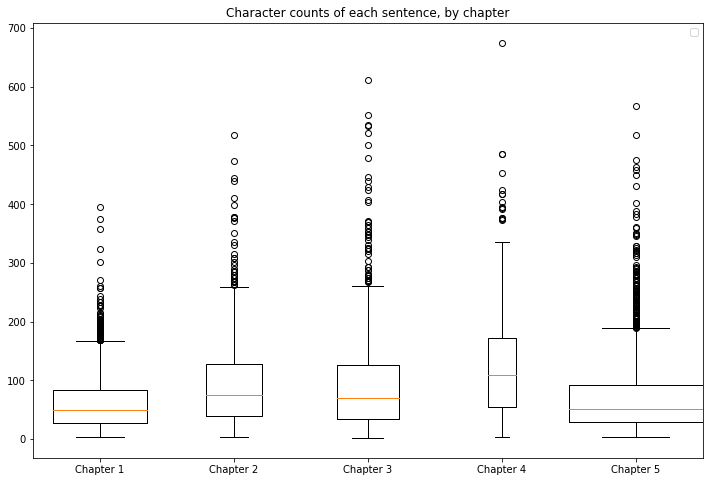

In [78]:
#Box and whisker plots
#Widths of boxes are lengths of chapters in proportion to Chapter 5.
box_widths = [df1['char_count'].shape[0] / df5['char_count'].shape[0],
 df2['char_count'].shape[0] / df5['char_count'].shape[0],
 df3['char_count'].shape[0] / df5['char_count'].shape[0],
 df4['char_count'].shape[0] / df5['char_count'].shape[0],
 df5['char_count'].shape[0] / df5['char_count'].shape[0]
]
#Labels for box and whisker plots
box_labels = ['Chapter 1', 'Chapter 2', 'Chapter 3', 'Chapter 4', 'Chapter 5']

#First box and whisker plot
#Chapter 4 has the longest sentences overall.
#Widths of boxes are lengths of chapters in proportion to Chapter 5.

fig = plt.figure(figsize = (12, 8))
plt.boxplot([df1['char_count'],
             df2['char_count'],
             df3['char_count'],
             df4['char_count'],
             df5['char_count']
            ], 
            labels = box_labels,
            widths = box_widths
           )
plt.legend()
plt.title('Character counts of each sentence, by chapter')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Mean token length for each sentence, by chapter')

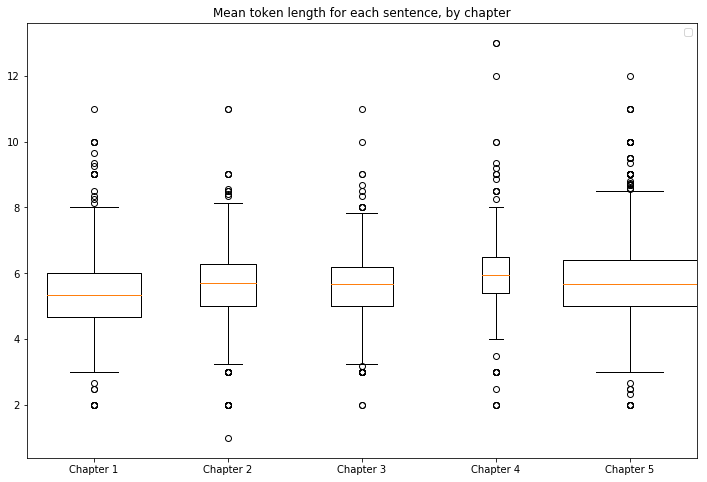

In [79]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([df1['mean_token_len'],
             df2['mean_token_len'],
             df3['mean_token_len'],
             df4['mean_token_len'],
             df5['mean_token_len']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.legend()
plt.title('Mean token length for each sentence, by chapter')

Text(0.5, 1.0, 'Token count of each sentence, by chapter')

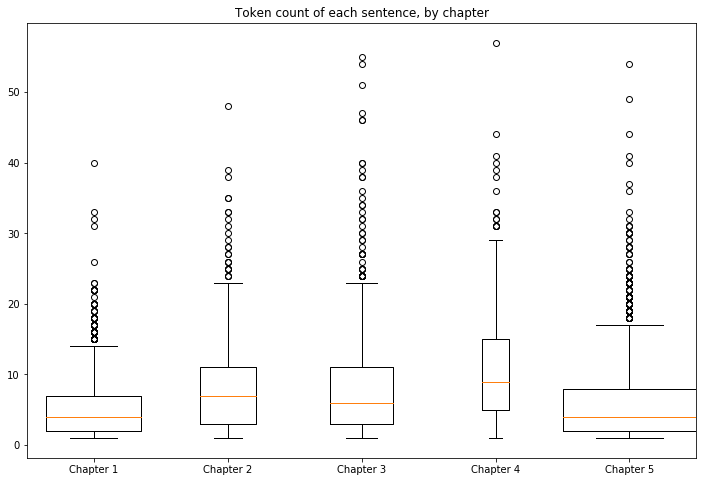

In [80]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([df1['token_count'],
             df2['token_count'],
             df3['token_count'],
             df4['token_count'],
             df5['token_count']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.title('Token count of each sentence, by chapter')

In [ ]:
#Observations from box plots: Chapter 4 has longer character counts of its sentences
#and longer token counts (lengths of its words)

# Principal component analysis: 300 vectors down to 3
## Sentence 'mean vectors'

In [147]:
df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0]

(1457, 858, 960, 422, 2058)

In [170]:
#First look at sentence vectors, not normalized
df = df1[['tokens', 'mean_vector', 'label']].append([
                                                    df2[['tokens', 'mean_vector', 'label']], 
                                                    df3[['tokens', 'mean_vector', 'label']],
                                                    df4[['tokens', 'mean_vector', 'label']],
                                                    df5[['tokens', 'mean_vector', 'label']]
                                                    ], ignore_index = True)
#Rename columns to work with pca function
df.rename({'mean_vector': 'vector', 'tokens': 'token'}, axis = 1, inplace = True)
#Get PCA for this df
df_pca = do_pca(df)


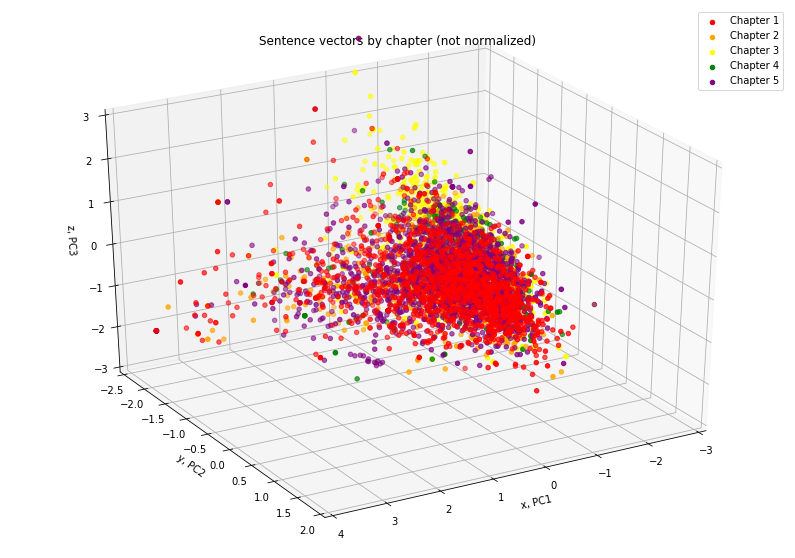

In [197]:
xyz = [-3, 4, -2.5, 2, -3, 3]
title = 'Sentence vectors by chapter (not normalized)'
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]

#Plot chapters together to see distribution of PCA in 3d
plot_pca(df_pca, plot_list, xyz = xyz, figsize = (14,10), 
          legend = True, title = title)

### Looking at individual plots after spotting a green cluster at azim 60 elev -90

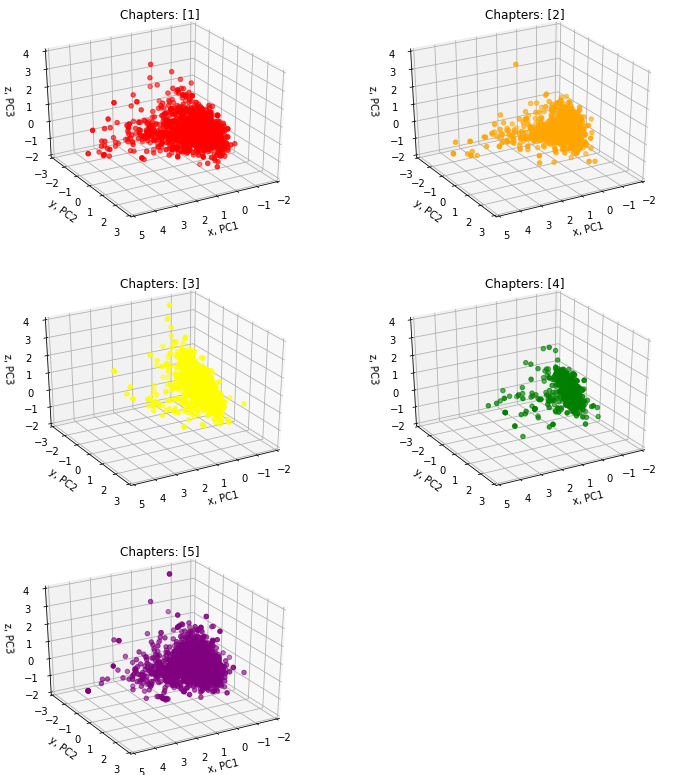

In [198]:
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]
xyz = [-2, 5, -3, 3, -2, 4]

#Draw separate plots for sentence vectors in each chapter
plot_pca(df_pca, plot_list, xyz = xyz)

### Try with PCA = 2?

## Individual  word tokens as vectors

In [6]:
wv_df1 = word_vec_df(ch1, 1)
wv_df2 = word_vec_df(ch2, 2)
wv_df3 = word_vec_df(ch3, 3)
wv_df4 = word_vec_df(ch4, 4)
wv_df5 = word_vec_df(ch5, 5)

In [13]:
#PRevious ones with old code
wv_df1.shape[0], wv_df1.shape[0], wv_df1.shape[0], wv_df1.shape[0], wv_df1.shape[0]

(2224, 3040, 3031, 2282, 4466)

In [275]:
wv_df1.shape[0], wv_df2.shape[0], wv_df3.shape[0], wv_df4.shape[0], wv_df5.shape[0]

(2220, 3031, 3013, 2272, 4437)

In [31]:
wv_df = wv_df1.append([wv_df2, wv_df3, wv_df4, wv_df5])
byword_pca = do_pca(wv_df)

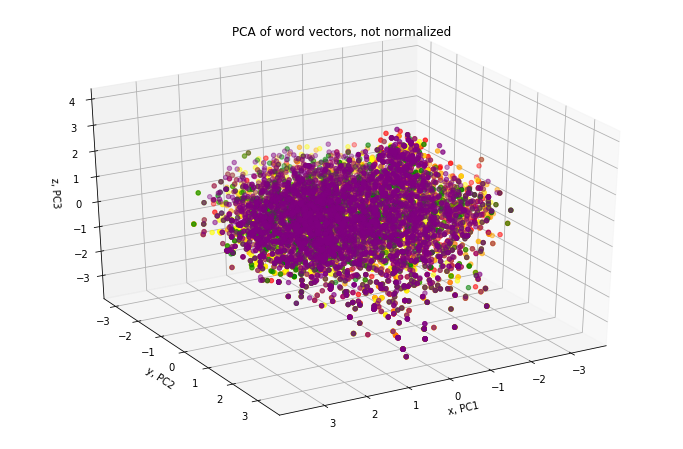

In [32]:
#Plot PCA of word vectors together
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]

plot_pca(byword_pca, plot_list, figsize = (12, 8), title = 'PCA of word vectors, not normalized')

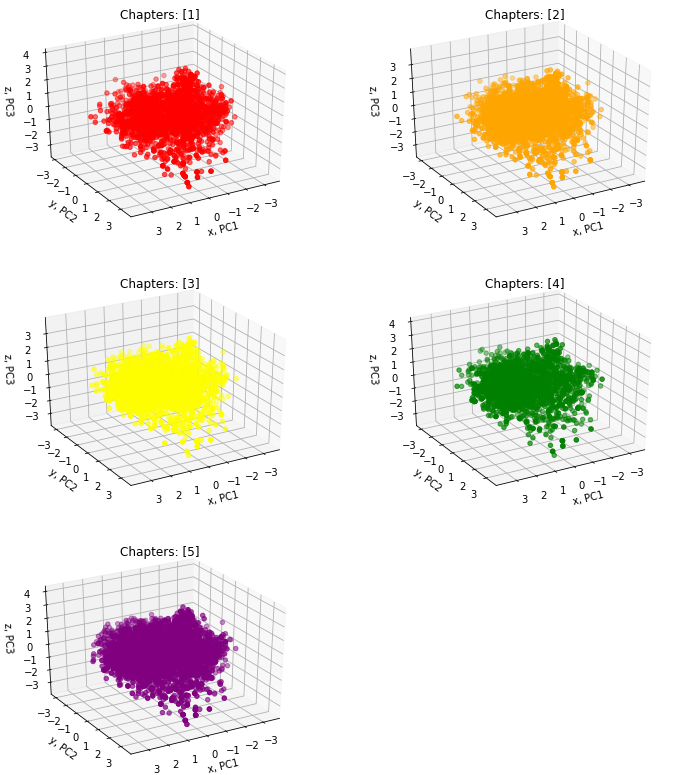

In [283]:
#Show each chapter as its own plot
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]

plot_pca(byword_pca, plot_list)

Plotting all word vectors yields basically a big blob.

### How about just the empty vectors?

In [24]:
empties = wv_df[[True if np.all(row == zeros) else False for row in wv_df['vector']]]

empty_pca = do_pca(empties)
empty_pca.head()

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/decomposition/pca.py:535: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


,PC1,PC2,PC3,label,token,vector
0,0.0,0.0,0.0,1,decentest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,1,balbus,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,1,oilsheet,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,1,tramhorse,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,1,seventysix,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


They all get coordinates of 0 0 0

### Will unique words look like anything when plotted?

In [8]:
zeros = np.zeros(300)

unique1 = appears_in(wv_df, wv_df1, 1)
unique2 = appears_in(wv_df, wv_df2, 2)
unique3 = appears_in(wv_df, wv_df3, 3)
unique4 = appears_in(wv_df, wv_df4, 4)
unique5 = appears_in(wv_df, wv_df5, 5)
uniq1_notna = unique1[[False if np.all(row == zeros) else True for row in unique1['vector']]]
uniq2_notna = unique2[[False if np.all(row == zeros) else True for row in unique2['vector']]]
uniq3_notna = unique3[[False if np.all(row == zeros) else True for row in unique3['vector']]]
uniq4_notna = unique4[[False if np.all(row == zeros) else True for row in unique4['vector']]]
uniq5_notna = unique5[[False if np.all(row == zeros) else True for row in unique5['vector']]]

In [285]:
#Tokens unique to chapter 1
print('unique:', unique1.shape[0], 'unique notna:', uniq1_notna.shape[0])
print('Total tokens in chapter:', len(ch1_byword['token'].values))
print('\n')
print('unique:', unique2.shape[0], 'unique notna:', uniq2_notna.shape[0])
print('Total tokens in chapter:', len(ch2_byword['token'].values))
print('\n')
print('unique:', unique3.shape[0], 'unique notna:', uniq3_notna.shape[0])
print('Total tokens in chapter:', len(ch3_byword['token'].values))
print('\n')
print('unique:', unique4.shape[0], 'unique notna:', uniq4_notna.shape[0])
print('Total tokens in chapter:', len(ch4_byword['token'].values))
print('\n')
print('unique:', unique5.shape[0], 'unique notna:', uniq5_notna.shape[0])
print('Total tokens in chapter:', len(ch5_byword['token'].values))

unique: 676 unique notna: 593
Total tokens in chapter: 2224


unique: 1033 unique notna: 933
Total tokens in chapter: 3040


unique: 1130 unique notna: 1047
Total tokens in chapter: 3031


unique: 719 unique notna: 616
Total tokens in chapter: 2282


unique: 2034 unique notna: 1812
Total tokens in chapter: 4466


In [33]:
#PCA for unique vectors, excluding empty vectors
unique_notna = uniq1_notna.append([uniq2_notna, uniq3_notna, uniq4_notna, uniq5_notna])
unique_notna_pca = do_pca(unique_notna)

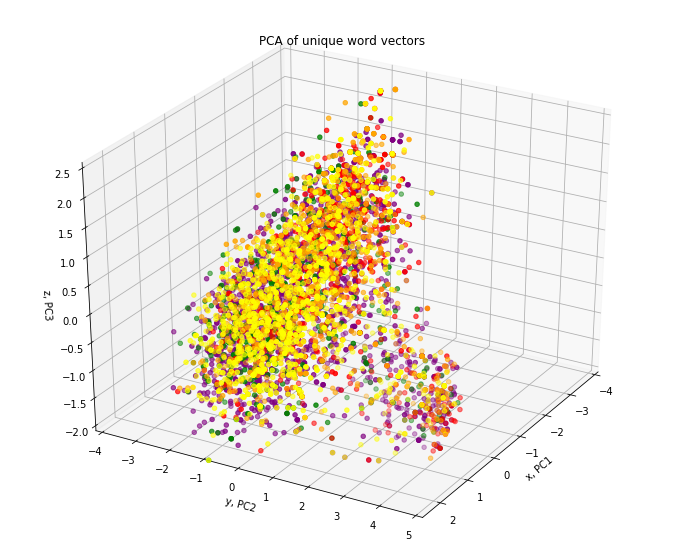

In [58]:
#Plot PCA of  unique word vectors together. Excludes NA vectors
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 30, figsize = (12,10), 
         title = 'PCA of unique word vectors')

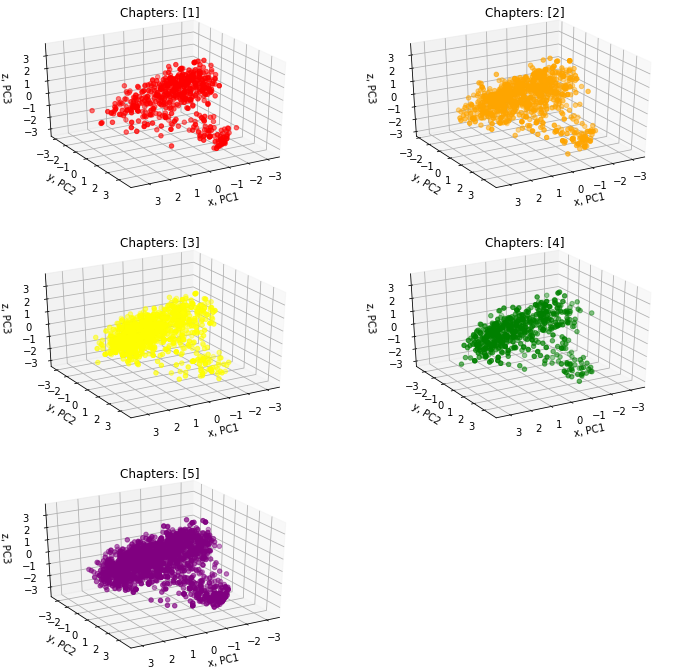

In [300]:
#Plot PCA of unique word vectors separately. Excludes NA vectors
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]

plot_pca(unique_notna_pca, plot_list, figsize = (12, 12))

### Amazing discovery re: the blob sticking out

In [52]:
#What's that blob in the corner?  'PC1' < -2, PC2' > -1, PC3' < -1

#For NON normalized unique tokens
#The blob is all names of people and names of places
xyz = [-10, 1, 1.5, 10, -10, 0]
blob_notna = isolate(unique_notna_pca, xyz = xyz)

In [53]:
blob_notna.shape[0]

406

In [57]:
blob_notna[blob_notna['label'] == 4].head(20)

,PC1,PC2,PC3,label,token,vector
2577,-1.897953,2.537042,-1.981929,4,fallon,"[-0.31196, -0.45359, 0.35115, -0.30015, -0.333..."
2659,0.687959,2.068458,-0.609345,4,incomprehensibility,"[-0.42997, -0.20738, 0.69519, -0.0875, -0.3223..."
2693,-0.354413,3.080951,-1.679034,4,stephanos,"[0.077424, 0.6294, 0.61113, -0.19598, 0.034914..."
2708,-1.341034,2.697462,-2.312048,4,connolly,"[-0.1873, 0.13365, 0.19859, 0.40769, 0.21909, ..."
2732,-1.271024,2.921608,-2.113004,4,virgil,"[-0.70464, 0.022901, 0.46336, -0.85965, 0.0795..."
2754,-1.010531,2.432713,-2.534428,4,hickey,"[-0.25472, -0.16254, -0.16472, -0.56155, 0.018..."
2775,-2.221066,1.965202,-2.691444,4,campbell,"[-0.31935, 0.57083, -0.0087218, -0.2612, 0.517..."
2781,-1.815227,2.801064,-2.169328,4,crosby,"[-0.52653, 0.29876, -0.47417, -0.64727, 0.5719..."
2813,-1.172586,2.680756,-2.247967,4,arras,"[0.5203, 0.20529, 0.40897, 0.078573, 0.35255, ..."
2823,-1.892186,2.177943,-2.631560,4,quaid,"[-0.48314, 0.40842, 0.43687, -0.16079, 0.4834,..."


### Can any patterns be discerned in parts of the linear mass?

In [94]:
#Government, politics, nations, courts
#Very few in chapter 1, a lot in chapter 5
xyz = [0, 3, -4, 0, -1.5, -1]
gov = isolate(unique_notna_pca, xyz)

In [95]:
gov.head(30)

,PC1,PC2,PC3,label,token,vector
175,0.232102,-1.220708,-1.072720,1,lessons,"[-0.054098, 0.53633, 0.18701, 0.29971, 0.22228..."
177,0.152082,-0.314075,-1.164174,1,plural,"[0.044639, -0.57824, -0.12311, -0.3099, 0.5196..."
209,1.472884,-1.117839,-1.327413,1,election,"[-0.19032, -0.18437, 0.84933, 0.10502, -0.3497..."
294,0.213447,-0.768435,-1.460073,1,corrections,"[-0.42964, 0.011994, -0.4992, -0.18752, -0.214..."
311,1.702960,-1.359960,-1.125539,1,nation,"[0.11286, 0.30514, 0.75578, -0.24538, 0.33715,..."
335,0.880560,-1.708734,-1.491854,1,languages,"[-0.16043, -0.96065, 0.048593, 0.11912, 0.8401..."
386,0.765577,-2.567256,-1.440786,1,funds,"[-0.33281, -0.32433, 0.29303, -0.15496, -0.632..."
387,0.836679,-0.259842,-1.233301,1,grammar,"[-0.43433, -0.63983, -0.51193, 0.3794, 0.24848..."
513,0.404235,-1.065344,-1.340521,1,filed,"[-0.060134, -0.36072, -0.13436, -0.14318, -0.4..."
643,0.727333,-0.295513,-1.135817,2,enlisted,"[0.43989, -0.18251, 0.61694, -0.071366, -0.250..."


In [89]:
gov.shape

(97, 6)

In [118]:
#A few army words but not as striking as 'gov'
xyz = [0, 1, -4, 0, -1, -0.5]
part = isolate(unique_notna_pca, xyz)

In [123]:
#Sports!!! Flags, winning, games
xyz = [-1, 0, -4, 0, -1, -0.5]
sports = isolate(unique_notna_pca, xyz)

In [124]:
sports.shape

(115, 6)

In [127]:
sports[sports['label'] == 5].head(50)

,PC1,PC2,PC3,label,token,vector
3216,-0.961179,-0.412275,-0.942370,5,handball,"[0.39708, 0.30808, 0.054974, -0.094401, 0.5119..."
3263,-0.342144,-0.890409,-0.764285,5,hedge,"[-0.13634, 0.023449, -0.33529, -0.26601, -0.01..."
3271,-0.357581,-3.173278,-0.693357,5,structure,"[0.027716, 0.15386, -0.074215, 0.10254, -0.379..."
3293,-0.867492,-1.944170,-0.507899,5,type,"[0.16337, 0.18641, -0.3839, -0.29178, -0.03551..."
3380,-0.086815,-2.602221,-0.516218,5,applied,"[0.10036, 0.029049, -0.10653, -0.42076, -0.396..."
3403,-0.880845,-1.970912,-0.530570,5,item,"[-0.099699, 0.0073687, 0.10439, 0.47411, -0.40..."
3430,-0.009505,-2.369109,-0.974214,5,usage,"[-0.45023, 0.20003, 0.065971, -0.10796, -0.492..."
3486,-0.756086,-0.550171,-0.935262,5,seaport,"[0.38999, -0.50139, -0.56362, -0.19426, 0.3730..."
3518,-0.180308,-2.178447,-0.970651,5,patented,"[-0.61534, -0.10878, -0.35477, -0.15779, -0.20..."
3550,-0.816730,-1.914889,-0.843537,5,machinery,"[-0.10723, 0.49945, 0.5774, -0.55133, 0.046128..."


In [135]:
#Commercial buildings, waterfront
xyz = [-3, -1, -4, 0, -1, -0.5]
water = isolate(unique_notna_pca, xyz)

In [136]:
water.shape

(40, 6)

In [130]:
water.head(40)

,PC1,PC2,PC3,label,token,vector
36,-1.614923,-1.471832,-0.548161,1,flowerbeds,"[0.86166, 0.31724, -0.44249, -1.1644, 0.031776..."
69,-1.272645,-0.944079,-0.504792,1,swop,"[0.23923, -0.11999, -0.34888, 0.47162, -0.0720..."
327,-1.187101,-1.536920,-0.960800,1,cards,"[-0.54786, -0.060409, -0.34341, -0.78909, 0.76..."
380,-1.751579,-0.884520,-0.529769,1,tower,"[0.17543, -0.2003, -0.14252, -0.3409, 0.02893,..."
596,-1.512829,-0.868234,-0.736521,2,mills,"[-0.13279, 0.42242, 0.17068, -0.42765, -0.1311..."
807,-1.269272,-0.463605,-0.672218,2,hash,"[0.43504, -0.044163, 0.36793, 0.11832, 0.00267..."
828,-1.829534,-0.415526,-0.958714,2,vans,"[0.61935, 0.19209, 0.66574, -0.72618, 0.57477,..."
929,-1.192592,-0.856289,-0.821062,2,coin,"[-0.02913, -0.15299, 0.7377, 0.12381, 0.075353..."
963,-1.205584,-1.040310,-0.533810,2,coins,"[-0.062746, -0.44037, 0.28785, -0.070434, -0.2..."
973,-1.135181,-1.226767,-0.758362,2,holiday,"[0.25136, 0.17884, 0.15883, -0.38519, 0.27954,..."


In [170]:
#Stuff: nouns, very few verbs
xyz = [-2, -1, -4, 0, -0.5, -0]
stuff = isolate(unique_notna_pca, xyz)

In [171]:
stuff.shape

(73, 6)

In [173]:
#part[part['label'] == 2]
stuff.head(50)

,PC1,PC2,PC3,label,token,vector
11,-1.457461,-1.473255,-0.231686,1,cabinet,"[0.17267, 0.20519, 0.58701, -0.3253, 0.29588, ..."
15,-1.389015,-0.566135,-0.014574,1,sprinter,"[0.4845, 0.18321, -0.56516, 0.0045935, 0.07894..."
43,-1.912393,-0.311121,-0.095717,1,fountain,"[0.48888, 0.17752, 0.20508, -0.63227, -0.0908,..."
68,-1.209695,-0.291322,-0.160637,1,quid,"[-0.50485, -0.13196, 0.42945, -0.50459, 0.2125..."
94,-1.485388,-0.198314,-0.406007,1,bowling,"[0.4649, 0.35732, 0.66747, -0.6381, 0.4932, -0..."
136,-1.278352,-0.920767,-0.335519,1,slate,"[0.35037, -0.019919, 0.4987, 0.19132, -0.02588..."
210,-1.070080,-2.047260,-0.037168,1,slabs,"[0.62378, 0.36095, 0.0041269, -0.1763, 0.26167..."
319,-1.582354,-1.731826,-0.275480,1,covers,"[0.091024, -0.13686, 0.071662, 0.20456, 0.0057..."
376,-1.578832,-1.629652,-0.068071,1,machine,"[-0.12538, 0.38888, 0.48011, -0.49002, -0.0036..."
451,-1.110467,-0.313069,-0.017174,1,playground,"[0.83016, -0.13578, 0.25167, -0.6397, 0.35788,..."


In [174]:
#IDEA: k nearest neighbors?
#2667	-2.376713	-0.010858	-0.081842	4	sandy
#2812	-2.579536	-0.781950	-0.204029	4	beach

#MOVE ON TO NEXT Z LEVEL STARTING HERE.
xyz = [2, 3, -4, 0, -0.5, -0]
part = isolate(unique_notna_pca, xyz)

In [ ]:
part.shape

In [ ]:
#part[part['label'] == 2]
part.head(50)

# RESUME HERE

### Train test split

In [ ]:
#Functions from Parrish

# def subtractv(coord1, coord2):
#     return [c1 - c2 for c1, c2 in zip(coord1, coord2)]

# def addv(coord1, coord2):
#     return [c1 + c2 for c1, c2 in zip(coord1, coord2)]

# def meanv(coords):
#     # assumes every item in coords has same length as item 0
#     sumv = [0] * len(coords[0])
#     for item in coords:
#         for i in range(len(item)):
#             sumv[i] += item[i]
#     mean = [0] * len(sumv)
#     for i in range(len(sumv)):
#         mean[i] = float(sumv[i]) / len(coords)
#     return mean


# #Convenience function
# def vec(s):
#     return nlp.vocab[s].vector

# # cosine similarity
# def cosine(v1, v2):
#     if norm(v1) > 0 and norm(v2) > 0:
#         return dot(v1, v2) / (norm(v1) * norm(v2))
#     else:
#         return 0.0
    
# def spacy_closest(token_list, vec_to_check, n=10):
#     return sorted(token_list,
#                   key=lambda x: cosine(vec_to_check, vec(x)),
#                   reverse=True)[:n]

# def sentvec(s):
#     sent = nlp(s)
#     return meanv([w.vector for w in sent])

# def spacy_closest_sent(space, input_str, n=10):
#     input_vec = sentvec(input_str)
#     return sorted(space,
#                   key=lambda x: cosine(np.mean([w.vector for w in x], axis=0), input_vec),
#                   reverse=True)[:n]

#Tinkering from Parrish:

# cosine(vec('dog'), vec('puppy')) > cosine(vec('trousers'), vec('pants'))
# spacy_closest(tokens5, vec("pie"))
# blue_to_sky = subtractv(vec("blue"), vec("sky"))
# spacy_closest(tokens5, addv(blue_to_sky, vec("grass")))

#spacy_closest(ch1_nlp_tokens, vec(ch1_nlp_tokens[0]))

#sents1 = list(ch3.sents)
#for sent in spacy_closest_sent(sents1, "I went to church this morning."):
#    print(sent.text)
#    print("---")

#From Parrish
#nlp.vocab['cheese'].vector

# Insight workflow
### Data cleaning:
- tokenize
- remove non-alphanumeric
- to lower case
- combine words with similar spellings
- lemmatize?

### Words into numbers
- bag words [0 0 0 0 0 1 0 0 ]

# Custom Functions

In [5]:
def stop(word):
    '''
    Parameters:
    word (str)
    '''
    stop_list = stopwords.words('english')
    stop_list += list(string.punctuation)
    stop_list += ['could', 'like', 'one', 'said', 'would', '\'s', '\'ll']
    
    if word.isalpha():
        if word.lower() not in stop_list:
            return word.lower()  

# FOR CONSTRUCTING DFS OF VECTORS ###########################
def word_vec_df(chapter, label):
    '''
    Constructs a df to track words in a chapter, each word's token,
    and each token's vector.
    Parameters:
    chapter (spacy.tokens.doc.Doc) The text of a chapter.
    label (int) The chapter number.
    Returns:
    df (pd.DataFrame)
    '''
   
    #Token for each word in the text that survives stoppage  
    #Only need unique tokens, so we take the set
    tokens = list(set([stop(t) for t in word_tokenize(chapter.text) if stop(t)]))
    
    #Vector for each token
    vectors = [nlp.vocab[t].vector for t in tokens]
    
    #Instantiate new df
    df = pd.DataFrame()
    #Build df columns from above lists
    df['token'] = tokens
    df['vector'] = vectors
    df['label'] = label
    
    return df

def sent_vec_df(chapter, labels):
    '''
    Consructs a df to track a chapter's sentences, each sentence's tokens,
    some stats on the tokens, each token's vector, and the 
    'mean vector' for each sentence's vectors.
   
    Parameters:
    chapter (spacy.tokens.doc.Doc) The text of a chapter.
    label (int) The chapter number.
    
    Returns:
    df (pd.DataFrame)
    '''
    #Turn spacy doc into lists of sentences as strings
    sentences = [str(s) for s in list(chapter.sents)]
    
    #Number of characters in each sentence
    char_counts = [len(s) for s in sentences]
   
    #The tokens for each sentence
    tokenized_sentences = [[stop(t) for t in word_tokenize(sentence) if stop(t)] \
                               for sentence in sentences]
    
    #Average length of token in each sentence
    mean_token_len = [np.mean([len(t) for t in tokens]
                             ) for tokens in tokenized_sentences]
    #Number of tokens in each sentence
    #(Those with 0 will be dropped later)
    token_counts = [len(t) for t in tokenized_sentences]
                               
    #The vector for each token
    vectorized_tokens = [[nlp.vocab[t].vector for t in tokenized_sent] \
                             for tokenized_sent in tokenized_sentences]
    
    #The 'mean vector' for each sentence's vectors
    #(Each mean vector is itself a 300-dimension vector like the originals)
    mean_vectors = [np.mean([v for v in vector_list], 
                           axis = 0
                          ) for vector_list in vectorized_tokens]
    
    #Instantiate new df
    df = pd.DataFrame()
    #Build df columns from above lists
    df['sentence'] = sentences
    df['char_count'] = char_counts
    df['tokens'] = tokenized_sentences
    df['mean_token_len'] = mean_token_len
    df['token_count'] = token_counts
    df['vectors'] = vectorized_tokens
    df['mean_vector'] = mean_vectors
    df['label'] = labels
    
    #Drop rows which don't have any tokens
    df = df[df['token_count'] != 0]
    
    return df

def appears_in(text, chap, label):
    '''
    Gets words that are unique to a chapter. Checks a chapter's words
    against the words in the rest of the text.
   
    Parameters:
    text (pd.DataFrame) The full text. (Requires either a sv_df or wv_df.)
    chap (pd.DataFrame) Just this chapter.
    label (int) This chapter's number.
    
    Return:
    df (pd.DataFrame)
    '''
    #List of words from other chapters
    other_chapters = text[text['label'] != label]['token'].values
    
    #List of words from this chapter
    this_chapter = chap['token'].values
    
    #List of bools for words unique to this chapter
    unique_words = [True if v not in other_chapters else False \
                     for v in this_chapter]
    df = chap[unique_words]
    return df

# PCA functions ##############################################################
def vec_to_col(df, veclen = 300):
    '''
    Turn a vector of dimensions x into x numerical columns. 
    Return the same df.
    #return df
    '''
    #Make each scalar in the 300-long vector into a column for the features
    for i in np.arange(0, veclen):
        df[str(i + 1)] = [v[i] for v in df['vector'].values]
    
    return df
    
def get_x_y(df):
    '''
    Helper function.
    Separate a df into features and target. Return two dfs.
    '''
    features = df.drop(['token', 'vector', 'label'], axis = 1, inplace = False)
    target = df['label']
    
    return features, target

def do_pca(df, veclen = 300, normalize = False, components = 3):    
    
    #Turn vectors into columns.
    df = vec_to_col(df)
    
    #Get features and target.
    features, target = get_x_y(df)
    
    if normalize:
        X = StandardScaler().fit_transform(features)
    else:
        X = features
        
    #Get principal components from features with PCA object
    pca = PCA(n_components = components)
    principalComponents = pca.fit_transform(X)

    # Create a new dataset fro principal components 
    pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
    pca_df['label'] = target.values
    pca_df['token'] = df['token'].values
    pca_df['vector'] = df['vector'].values
    
    return pca_df

def plot_pca(df, plot_list, 
             xyz = None,
             figsize = (12, 14),
             azim = 60, 
             elev = 30,
             legend = False,
             title = None):
    '''
    Draws a flexible figure of subplots, with as many as are listed
    in the plot list of dictionaries. Each subplot can have one or more
    scatters drawn together depending on how many key/val pairs are in
    the dict.
    Parameters:
    df (pd.DataFrame) Needs columns for 'PC1', 'PC2', and 'PC3.'
    plot_list (list) List of dictionaries. Each dict is a subplot with as many 
    scatters as there are key/val pairs in the dict. E.g. for one plot with one scatter,
    use a list with 1 dict with 1 key/val pair.
    xyz (list) List of limits for the three dimensions.
    figsize (tuple) Size of figure.
    azim (int): Horizontal view of the plot.
    elev (int): Vertical view of the plot.
    legend (bool): True if a legend should be drawn.
    title (str): Title of plot (only really if just one plot being shown.)
    
    Returns: 
    Draws a plot.
    '''
    #Get xyz limits for the plots.
    if xyz:
        xmin, xmax, ymin, ymax, zmin, zmax = xyz[0], xyz[1], xyz[2], xyz[3], xyz[4], xyz[5]
    
    #Get right number of rows whether length is even or odd.
    #Needed this instead of just rounding because of 'banker's rounding.'
    rows = (len(plot_list) // 2) + (len(plot_list) % 2)

    #Set columns. 1 if 1 plot, else 2.
    if len(plot_list) == 1:
        cols = 1
    else:
        cols = 2
    #Draw figure to hold all plots
    fig = plt.figure(figsize = figsize)    
    
    #Draw a subplot for each dict in the plot list.
    #If just one subplot should be drawn, put just one dict in the list.
    #The plot will fill the figure.
    for i in range(len(plot_list)): 
        ax = fig.add_subplot(rows, cols, (i + 1), projection='3d', azim = azim, elev = elev)
        if xyz: 
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            ax.set_zlim(zmin, zmax)
        
        #Draw each scatter within a subplot. 1 for each key/val pair in the dict.
        #(Allows for each subplot to show one or more scatters.)
        #together.
        for label, color in  plot_list[i].items():
            #Pull the data from the df corresponding to each label
            pca = df[df['label'] == label]
            #Draw a scatter for the data from each label
            ax.scatter(xs = pca['PC1'], ys = pca['PC2'], zs = pca['PC3'],
                  c = color, label = ('Chapter ' + str(label)))
        
        #Label axes for each subplot
        ax.set_xlabel('x, PC1')
        ax.set_ylabel('y, PC2')
        ax.set_zlabel('z, PC3')
        
        #Set legend for each subplot
        if legend:
            plt.legend()
        #Set title for each subplot
        if not title:
            plt.title('Chapters: ' + str(list(plot_list[i].keys())))
        else:
            plt.title(title)
    plt.show()
    
def isolate(df, xyz):
    '''
    Parameters:
    df (pd.DataFrame) Needs a 'label' column to work. Needs PC1, 2, and 3 columns.
    xyz (list) List of limits for PC1, 2, and 3.
   
    Returns:
    blob_df (pd.DataFrame) Section of the pca_df within the 
    spatial limits set by the parameters. The 'blob' within 
    a 'cube' on a 3d plot.
    '''
    xmin, xmax, ymin, ymax, zmin, zmax = xyz[0], xyz[1], xyz[2], xyz[3], xyz[4], xyz[5]
    
    blob = df[
                    ((df['PC1'] > xmin) & (df['PC1'] < xmax )) & \
                    ((df['PC2'] > ymin) & (df['PC2'] < ymax )) & \
                    ((df['PC3'] > zmin) & (df['PC3'] < zmax ))
                ]
    return blob
##############################################################

